## Marty Equations of Motion
Let's quickly get the dynamics of the hopper out of the way. We'll use 5 generalized coordinates: the position and angle of the body, the hip angle, and the length of the prismatic joint at the knee. We'll add actuator forces at both joints, and ground reaction forces at the foot. The activation of these forces will be controlled with complementarity constraints.

In [1]:
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,mul1,mul2,mll1,mll2 = sym.symbols(['m_{body}','m_{upper1}','m_{upper2}','m_{lower1}', 'm_{lower2}']) # mass
lb,lul1,lul2,lll1,lll2 = sym.symbols(['l_{body}','l_{upper1}','l_{upper2}','l_{lower1}', 'l_{lower2}']) # length
Inb,Inul1,Inul2,Inll1,Inll2 = sym.symbols(['I_{body}','I_{upper1}','I_{upper2}','I_{lower1}', 'I_{lower2}']) # moment of intertia

# generalized coordinates
x,y,thb,thul1,thll1,thul2,thll2 = sym.symbols(['x','y','\\theta_{body}','\\theta_{Uleg1}','\\theta_{Lleg1}', '\\theta_{Uleg2}', '\\theta_{Lleg2}'])
dx,dy,dthb,dthul1,dthll1,dthul2,dthll2 = sym.symbols(['\\dot{x}','\\dot{y}','\\dot{\\theta}_{body}','\\dot{\\theta}_{Uleg1}','\\dot{\\theta}_{Lleg1}','\\dot{\\theta}_{Uleg2}','\\dot{\\theta}_{Lleg2}'])
ddx,ddy,ddthb,ddthul1,ddthll1,ddthul2,ddthll2 = sym.symbols(['\\ddot{x}','\\ddot{y}','\\ddot{\\theta}_{body}','\\ddot{\\theta}_{Uleg1}','\\ddot{\\theta}_{Lleg1}','\\ddot{\\theta}_{Uleg2}','\\ddot{\\theta}_{Lleg2}'])

q = sym.Matrix([[x],[y],[thb],[thul1],[thll1],[thul2],[thll2]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthul1],[dthll1],[dthul2],[dthll2]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthul1],[ddthll1],[ddthul2],[ddthll2]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tauKn1,tauKn2,tauSh1,tauSh2,GRFx1,GRFy1,GRFx2,GRFy2 = sym.symbols(['\\tau_{Knee1}','\\tau_{Knee2}','\\tau_{Shoulder1}','\\tau_{Shoulder2}','Gx_{1}','Gy_{1}','Gx_{2}','Gy_{2}'])

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rul1 = sym.Matrix([[x + 0.5*lb*sym.cos(thb)+0.5*lul1*sym.sin(thul1+thb)],
                [y + 0.5*lb*sym.sin(thb) - 0.5*lul1*sym.cos(thb + thul1)],
                [thb + thul1]])

rul2 = sym.Matrix([[x - 0.5*lb*sym.cos(thb)+0.5*lul2*sym.sin(thul2+thb)],
                [y - 0.5*lb*sym.sin(thb) - (0.5*lul2)*sym.cos(thb + thul2)],
                [thb + thul2]])   

rll1 = sym.Matrix([[x + 0.5*lb*sym.cos(thb)+(lul1)*sym.sin(thul1+thb)+0.5*lll1*sym.sin(thb + thul1 + thll1)],
                [y + 0.5*lb*sym.sin(thb) - lul1*sym.cos(thb + thul1) - 0.5*lll1*sym.cos(thb + thul1 + thll1)],
                [thb + thul1 + thll1]])

rll2 = sym.Matrix([[x - 0.5*lb*sym.cos(thb)+(lul2)*sym.sin(thul2+thb)+0.5*lll2*sym.sin(thb + thul2 + thll2)],
                [y - 0.5*lb*sym.sin(thb) - (lul2)*sym.cos(thb + thul2) - 0.5*lll2*sym.cos(thb + thul2 + thll2)],
                [thb + thul2 + thll2]])


# the Jacobians
Jb = rb.jacobian(q)
Jul1 = rul1.jacobian(q)
Jul2 = rul2.jacobian(q)
Jll1 = rll1.jacobian(q)
Jll2 = rll2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vul1 = Jul1*dq
vul2 = Jul2*dq
vll1 = Jll1*dq
vll2 = Jll2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Mul1 = sym.Matrix([[mul1,mul1,Inul1]])
Mul2 = sym.Matrix([[mul2,mul2,Inul2]])
Mll1 = sym.Matrix([[mll1,mll1,Inll1]])
Mll2 = sym.Matrix([[mll2,mll2,Inll2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Mul1*sym.matrix_multiply_elementwise(vul1,vul1) + 0.5*Mul2*sym.matrix_multiply_elementwise(vul2,vul2) + 0.5*Mll1*sym.matrix_multiply_elementwise(vll1,vll1) + 0.5*Mll2*sym.matrix_multiply_elementwise(vll2,vll2)
T = T[0]
V = mb*g*rb[1] + mul1*g*rul1[1] + mul2*g*rul2[1] + mll1*g*rll1[1] + mll2*g*rll2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tauSh1-tauSh2]])
tau_ul1 = sym.Matrix([[0],[0],[tauSh1-tauKn1]])
tau_ul2 = sym.Matrix([[0],[0],[tauSh2-tauKn2]])
tau_ll1 = sym.Matrix([[0],[0],[tauKn1]])
tau_ll2 = sym.Matrix([[0],[0],[tauKn2]])


#F_ul1 = sym.Matrix([[-FK1*sym.sin(thb+thul1)],[FK1*sym.cos(thb+thul1)],[0]])
#F_ll1 = sym.Matrix([[FK1*sym.sin(thb+thul1)],[-FK1*sym.cos(thb+thul1)],[0]])

#F_ul2 = sym.Matrix([[-FK2*sym.sin(thb+thul1)],[FK2*sym.cos(thb+thul1)],[0]])
#F_ll2 = sym.Matrix([[FK2*sym.sin(thb+thul1)],[-FK2*sym.cos(thb+thul1)],[0]])

GRF_l1 = sym.Matrix([[GRFx1],[GRFy1],[0.5*lll1*GRFx1*sym.cos(thb+thul1+thll1)+0.5*lll1*GRFy1*sym.sin(thb+thul1+thll1)]])
GRF_l2 = sym.Matrix([[GRFx2],[GRFy2],[0.5*lll2*GRFx2*sym.cos(thb+thul2+thll2)+0.5*lll2*GRFy2*sym.sin(thb+thul2+thll2)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_ul1).transpose()*Jul1[:,j]+(GRF_l1+tau_ll1).transpose()*Jll1[:,j]+(tau_ul2).transpose()*Jul2[:,j]+(GRF_l2+tau_ll2).transpose()*Jll2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

In [2]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,mul1,mll1,mul2,mll2,lb,lul1,lll1,lul2,lll2,
            Inb,Inul1,Inll1,Inul2,Inll2,
            x,y,thb,thul1,thll1,thul2,thll2,
            dx,dy,dthb,dthul1,dthll1,dthul2,dthll2,
            ddx,ddy,ddthb,ddthul1,ddthll1,ddthul2,ddthll2,
            tauKn1,tauKn2,tauSh1,tauSh2,GRFx1,GRFx2,GRFy1,GRFy2]

lambEOM = {}

DOFs = ['x','y','thb','thul1','thll1','thul2','thll2']

for dof_i, dof in enumerate(DOFs):
    lambEOM[dof] = sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])

In [3]:
TDOFs = ['x','y'] # translational DOFs - i.e. the ones that the foot has
ctsP = ['front', 'rear'] #leg and foot 1 is fron and 2 is rear
#TDOFs = [('x',1), ('y', 1), ('x', 2), ('y', 2)]

# foot position
pfoot1 = sym.Matrix([[x + 0.5*lb*sym.cos(thb)+(lul1)*sym.sin(thul1+thb)+lll1*sym.sin(thb + thul1 + thll1)],
                    [y + 0.5*lb*sym.sin(thb) - lul1*sym.cos(thb + thul1) - lll1*sym.cos(thb + thul1 + thll1)]])

pfoot2 = sym.Matrix([[x - 0.5*lb*sym.cos(thb)+(lul2)*sym.sin(thul2+thb)+0.5*lll2*sym.sin(thb + thul2 + thll2)],
                     [y - 0.5*lb*sym.sin(thb) - (lul2)*sym.cos(thb + thul2) - lll2*sym.cos(thb + thul2 + thll2)]])
# foot velocity
vfoot1 = pfoot1.jacobian(q)*dq

vfoot2 = pfoot2.jacobian(q)*dq

lamb_pfoot = {}
#lamb_pfoot = {}
lamb_vfoot = {}
#lamb_vfoot2 = {}

#for dof_i, dof in enumerate(['x','y']):
for dof_i, dof in enumerate(TDOFs):
    lamb_pfoot[dof, ctsP[0]] = sym.lambdify(sym_list,pfoot1[dof_i],modules = [func_map])
    lamb_pfoot[dof, ctsP[1]] = sym.lambdify(sym_list,pfoot2[dof_i],modules = [func_map])

    lamb_vfoot[dof, ctsP[0]] = sym.lambdify(sym_list,vfoot1[dof_i],modules = [func_map])
    lamb_vfoot[dof, ctsP[1]] = sym.lambdify(sym_list,vfoot2[dof_i],modules = [func_map])

## The Pyomo Model

In [39]:
# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import numpy as np

from IPython.display import display #for pretty printing

# create the model
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

# for sprint task
#N = 100 

# for sanity checks
N = 60
m.N = RangeSet(N) 

# sets can have multidimensional indices
# (probably a little gratuitous for such a simple model, but thought I'd show you anyway)
links = [('body',1),('leg1',1),('leg1',2),('leg2', 1),('leg2', 2)]
m.L = Set(dimen=2, initialize = links)

m.DOF = Set(initialize = DOFs) # the coordinates for each link
m.TDOF = Set(initialize = TDOFs) # world-frame coordinates for contact variables

In [40]:
# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

# whenever a multidimensional set is passed to a function, the index is expanded (infuriatingly enough...)
# so every function indexed on L needs to expect two inputs from that set 
# I've called them l = [lb, ln] for 'branch' and 'number'

def get_m(n, lb, ln):
    if lb == 'body':
        return 7.568
    elif ln == 2:
        return 0.226
    else: return 1.01
# note that the masses add up to 1
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.566
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# joint forces
joints = ['shoulder1', 'knee1', 'shoulder2', 'knee2']
m.J = Set(initialize = joints)
m.fj = Var(m.N, m.J) # net force at each joint

m.cts = Set(initialize = ctsP)
# ground reaction forces
m.GRF = Var(m.N, m.TDOF, m.cts)
#m.GRF = Var(m.N, m.TDOF)

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)
        m.q[n,'thb'].setlb(-0.45*np.pi)
        m.q[n,'thb'].setub(0.45*np.pi)
        m.q[n,'thul1'].setlb(-0.75*np.pi)
        m.q[n,'thul1'].setub(0.69)
        m.q[n,'thul2'].setlb(-0.75*np.pi)
        m.q[n,'thul2'].setub(0.69)
        m.q[n,'thll1'].setlb(0.89)
        m.q[n,'thll1'].setub(2.82)
        m.q[n,'thll2'].setlb(0.89)
        m.q[n,'thll2'].setub(2.82)
        # m.q[n,'r1'].setlb(0)
        # m.q[n,'r1'].setub(0.5)
        # m.q[n,'r2'].setlb(0)
        # m.q[n,'r2'].setub(0.5)
        
    m.fj[n,'shoulder1'].setlb(-23.7)
    m.fj[n,'shoulder1'].setub(23.7)
    m.fj[n,'knee1'].setlb(-35.55)
    m.fj[n,'knee1'].setub(35.55)
    m.fj[n,'shoulder2'].setlb(-23.7)
    m.fj[n,'shoulder2'].setub(23.7)
    m.fj[n,'knee2'].setlb(-35.55)
    m.fj[n,'knee2'].setub(35.55)

    m.GRF[n,('y'), 'front'].setlb(0)
    m.GRF[n,('y'), 'rear'].setlb(0)
    
    #m.GRF[n,('y',1)].setlb(0)
    #m.GRF[n,('y',2)].setlb(0)

In [41]:
# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.0))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# Equations of motion -----------------------------------------------------

# if you have a bunch of lambdify functions, it's helpful to create a function to deliver the list of variables each time
def get_var_list(m,n):
    var_list = [m.g,m.m[('body',1)],m.m[('leg1',1)],m.m[('leg1',2)],m.m[('leg2',1)],m.m[('leg2',2)],
                m.len[('body',1)],m.len[('leg1',1)],m.len[('leg1',2)],m.len[('leg2',1)],m.len[('leg2',2)],
                m.In[('body',1)],m.In[('leg1',1)],m.In[('leg1',2)],m.In[('leg2',1)],m.In[('leg2',2)],
                m.q[n,'x'],m.q[n,'y'],m.q[n,'thb'],m.q[n,'thul1'],m.q[n,'thll1'],m.q[n,'thul2'],m.q[n,'thll2'],
                m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'thb'],m.dq[n,'thul1'],m.dq[n,'thll1'],m.dq[n,'thul2'],m.dq[n,'thll2'],
                m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'thb'],m.ddq[n,'thul1'],m.ddq[n,'thll1'],m.ddq[n,'thul2'],m.ddq[n,'thll2'],
                m.fj[n,'shoulder1'],m.fj[n,'knee1'],m.fj[n,'shoulder2'],m.fj[n,'knee2'],
                m.GRF[n,'x','front'],m.GRF[n,'y','front'],m.GRF[n,'x','rear'],m.GRF[n,'y','rear']]
                #m.GRF[n,('x',1)],m.GRF[n,('y',1)],m.GRF[n,('x',2)],m.GRF[n,('y',2)]]
    return var_list

def dynamics(m,n,dof):
    var_list = get_var_list(m,n)
    return lambEOM[dof](*var_list) == 0
m.dynamics = Constraint(m.N, m.DOF, rule = dynamics)

In [42]:
# GROUND INTERACTIONS newest-------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 0.7) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng']
m.sgn = Set(initialize = signs)

# variables
# (I had that set error while trying to set up these default bounds. That's why I pointed it out.)

m.footy = Var(m.N,m.cts, bounds = (0.0,None)) # foot position
m.footdx = Var(m.N, m.sgn, m.cts, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, m.cts, bounds = (0.0,None))

m.Gx = Var(m.N, m.sgn, m.cts, bounds = (0.0,None)) # signed components of friction force

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.cts,m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables

def def_footy(m,n,cts):
    var_list = get_var_list(m,n)
    return m.footy[n,cts] == lamb_pfoot['y',cts](*var_list)
m.def_footy = Constraint(m.N,m.cts, rule = def_footy,)

def def_footdx(m,n,cts):
    var_list = get_var_list(m,n)
    return m.footdx[n,'ps', cts] - m.footdx[n,'ng', cts] == lamb_vfoot['x', cts](*var_list)
m.def_footdx = Constraint(m.N,m.cts, rule = def_footdx)

def get_Gx(m,n,cts):
    return m.GRF[n,'x', cts] == m.Gx[n,'ps', cts] - m.Gx[n,'ng', cts]
m.get_Gx = Constraint(m.N,m.cts, rule = get_Gx)

def def_friction_cone(m,n,cts):
    return m.friction_cone[n, cts] == m.mu*m.GRF[n,'y', cts] - (m.Gx[n,'ps', cts] + m.Gx[n,'ng', cts])
m.def_friction_cone = Constraint(m.N,m.cts, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n,cts):
    if n < N:
        return m.footy[n+1, cts]*m.GRF[n,'y', cts]  <= m.ground_penalty[n,cts,'contact']
        # notice that the GRF is complemented with the foot height at the NEXT node
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N,m.cts, rule = ground_contact)

# friction
def ground_friction(m,n,cts):
    return (m.footdx[n,'ps', cts]+m.footdx[n,'ng', cts])*m.friction_cone[n,cts] <= m.ground_penalty[n,cts,'friction'] 
m.ground_friction = Constraint(m.N,m.cts, rule = ground_friction)

# slipping
def ground_slip_ps(m,n,cts):
    return m.footdx[n,'ps', cts]*m.Gx[n,'ps', cts] <= m.ground_penalty[n,cts,'slip_ps']
m.ground_slip_ps = Constraint(m.N,m.cts, rule = ground_slip_ps)

def ground_slip_ng(m,n,cts):
    return m.footdx[n,'ng', cts]*m.Gx[n,'ng', cts] <= m.ground_penalty[n,cts,'slip_ng']
m.ground_slip_ng = Constraint(m.N,m.cts, rule = ground_slip_ng)

def feet_below_body(m,n,cts):
    return m.footy[n, cts] <= m.q[n,'y']
m.feet_below_body = Constraint(m.N,m.cts, rule = feet_below_body)



In [43]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    H = sum(-m.q[k,'y'] for k in range (1,N+1) )
    penalty_sum = sum([(m.ground_penalty[n,'front',gc]+m.ground_penalty[n,'rear',gc]) for n in range(1,N+1) for gc in ground_constraints])
    # ain't single-line for loops grand?
#     return T+1000*penalty_sum

    return penalty_sum # for sanity checks
m.Cost = Objective(rule = CostFun)

In [11]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof != 'y':
        m.q[1,dof].fix(0) # neutral posture
m.footy[1,'front'].fix(3.1)
m.footy[1, 'rear'].fix(3.1)

for n in range(1,N+1):
    for j in joints:
        m.fj[n,j].fix(0) # no forces

In [34]:
# # LOW DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof not in ['y']:
        m.q[1,dof].fix(0) # neutral posture
m.footy[1, 'front'].fix(0.15) # start near the ground
m.footy[1, 'rear'].fix(0.15) # start near the ground

#m.footy[15, 'front'].fix(0) # force it to land
#m.footy[15, 'rear'].fix(0) # force it to land

for n in range(1,N+1):
    for j in joints:
        m.fj[n,j].fix(0) # no forces

In [46]:
# # LOW DROP Neutral position -----------------------------------------------------------------------------------------------------------------

# initial condition
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof not in ['y', 'thul1', 'thll1', 'thul2', 'thll2']:
        m.q[1,dof].fix(0) # neutral posture
m.q[1,'thul1'].fix(-0.25*np.pi)
m.q[1,'thll1'].fix(0.5*np.pi)
m.q[1,'thul2'].fix(-0.25*np.pi)
m.q[1,'thll2'].fix(0.5*np.pi)
m.footy[1, 'front'].fix(0.1) # start near the ground
m.footy[1, 'rear'].fix(0.1) # start near the ground

#m.footy[15, 'front'].fix(0) # force it to land
#m.footy[15, 'rear'].fix(0) # force it to land

for n in range(1,N+1):
    for j in joints:
        m.fj[n,j].fix(0) # no forces

In [42]:
# # # STANDING ------------------------------------------------------------------------------------------------------------------

# initial condition rest and neutral pose
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof not in ['y', 'thul1', 'thll1', 'thul2', 'thll2']:
        m.q[1,dof].fix(0) # neutral posture
# m.q[1,'thul1'].fix(-0.25*np.pi)
# m.q[1,'thll1'].fix(0.5*np.pi)
# m.q[1,'thul2'].fix(-0.25*np.pi)
# m.q[1,'thll2'].fix(0.5*np.pi)
# m.q[1, 'y'].setlb(0.4)
# m.q[1,'thul1'].setub(-0.25*np.pi)
# m.q[1,'thll1'].setlb(0.5*np.pi)
# m.q[1,'thul2'].setub(-0.25*np.pi)
# m.q[1,'thll2'].setlb(0.5*np.pi)

for n in range(1,N+1):
     # must stay grounded for the full time
    m.q[n, 'thb'].setlb(-0.01)
    m.q[n, 'thb'].setub(0.01)
    m.q[n, 'y'].fix(0.65)
    m.q[n, 'x'].fix(0)
    m.q[n,'thul1'].setub(-0.2*np.pi)
    m.q[n,'thll1'].setlb(0.5*np.pi)
    m.q[n,'thul2'].setub(-0.2*np.pi)
    m.q[n,'thll2'].setlb(0.5*np.pi)
    m.footy[n, 'front'].fix(0)
    m.footy[n, 'rear'].fix(0)

# for n in range(1,N+1):
#     for j in joints:
#         m.fj[n,j].fix(0) # no forces

# for n in range(1,N+1):
#     for j in joints:
#         if j != 'knee': # needs knee force to maintain ROM limits of prismatic joint
#             m.fj[n,j].fix(0) # no forces

In [44]:
# # Vertical HOP -----------------------------------------------------------------------------------------------------------------------
# initial condition rest and neutral pose
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof not in ['y', 'thul1', 'thll1', 'thul2', 'thll2']:
        m.q[1,dof].fix(0) # neutral posture
# m.q[1,'thul1'].fix(-0.25*np.pi)
# m.q[1,'thll1'].fix(0.5*np.pi)
# m.q[1,'thul2'].fix(-0.25*np.pi)
# m.q[1,'thll2'].fix(0.5*np.pi)
m.q[1, 'y'].setlb(0.3)
m.q[1, 'y'].setub(0.7)
m.q[1,'thul1'].setub(-0.15*np.pi)
# m.q[1,'thll1'].setlb(0.4*np.pi)
m.q[1,'thul2'].setub(-0.15*np.pi)
# m.q[1,'thll2'].setlb(0.4*np.pi)


m.footy[1, 'front'].fix(0) # start on the ground
m.footy[1, 'rear'].fix(0) # start on the ground



# midpoint
m.q[N/2,'thul1'].setub(-0.1*np.pi)
m.q[N/2,'thll1'].setub(0.55*np.pi)
m.q[N/2,'thul2'].setub(-0.1*np.pi)
m.q[N/2,'thll2'].setub(0.55*np.pi)
m.footy[N/2, 'front'].setlb(0.4)
m.footy[N/2, 'rear'].setlb(0.4)
m.q[N/2, 'y'].setlb(1)
m.q[N/2, 'thb'].fix(0)

#Landing brace
# m.dq[N, 'x'].setub(0.2)
m.q[N-10, 'thb'].setub(0.1)
m.q[N-10, 'thb'].setlb(-0.1)

m.q[N-10,'thul1'].setub(-0.25*np.pi)
m.q[N-10,'thll1'].setub(0.5*np.pi)
m.q[N-10,'thul2'].setub(-0.25*np.pi)
m.q[N-10,'thll2'].setub(0.5*np.pi)

for n in range(N-5,N):
    m.footy[n, 'front'].fix(0) # end near the ground
    m.footy[n, 'rear'].fix(0) # end near the ground
    m.q[n, 'thb'].setub(0.05)
    m.q[n, 'thb'].setlb(-0.5)
    
# final condition
m.footy[N, 'front'].fix(0) # end near the ground
m.footy[N, 'rear'].fix(0) # end near the ground
m.dq[N, 'x'].setub(0.2)
m.q[N, 'x'].setub(0.15)
m.dq[N, 'y'].setlb(-1)
#m.q[N, 'y'].setub(0.3)
m.q[N, 'thb'].fix(0)

m.q[N,'thul1'].setub(-0.25*np.pi)
m.q[N,'thll1'].setub(0.8*np.pi)
m.q[N,'thul2'].setub(-0.25*np.pi)
m.q[N,'thll2'].setub(0.8*np.pi)

m.footdx[N, 'ps', 'front'].fix(0) 
m.footdx[N, 'ps', 'rear'].fix(0) 
m.footdx[N, 'ng','front'].fix(0) 
m.footdx[N, 'ng','rear'].fix(0) 

In [ ]:
for n in range(N-5,N+1):
    print(n)

In [81]:
# # Jump though hoop in front of it -----------------------------------------------------------------------------------------------------------------------
# initial condition rest and neutral pose
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof not in ['y', 'thul1', 'thll1', 'thul2', 'thll2']:
        m.q[1,dof].fix(0) # neutral posture
# m.q[1,'thul1'].fix(-0.25*np.pi)
# m.q[1,'thll1'].fix(0.5*np.pi)
# m.q[1,'thul2'].fix(-0.25*np.pi)
# m.q[1,'thll2'].fix(0.5*np.pi)

m.q[1, 'y'].setlb(0.3)
m.q[1,'thul1'].setub(-0.15*np.pi)
m.q[1,'thll1'].setlb(0.4*np.pi)
m.q[1,'thul2'].setub(-0.25*np.pi)
m.q[1,'thll2'].setlb(0.4*np.pi)

m.footy[1, 'front'].fix(0) # start on the ground
m.footy[1, 'rear'].fix(0) # start on the ground

# midpoint(hoop) fit through 0.5m radius hoop 30cm off ground
m.footy[N/2, 'front'].setlb(0.4)
m.footy[N/2, 'rear'].setlb(0.4)
m.q[N/2, 'y'].setub(1.2)
m.q[N/2,'x'].setlb(0.6)
#m.q[N/2, 'x'].setlb(1)
#m.q[N/2, 'thb'].fix(0)


# final condition
m.footy[N, 'front'].fix(0) # start near the ground
m.footy[N, 'rear'].fix(0) # start near the ground
m.q[N, 'thb'].fix(0)
m.q[N, 'x'].setlb(1.5)
m.q[N, 'y'].setlb(0.3)

# m.q[N,'thul1'].fix(-0.25*np.pi)
# m.q[N,'thll1'].fix(0.5*np.pi)
# m.q[N,'thul2'].fix(-0.25*np.pi)
# m.q[N,'thll2'].fix(0.5*np.pi)

#soft unnatural position bound
m.q[N,'thul1'].setub(-0.15*np.pi)
m.q[N,'thll1'].setlb(0.35*np.pi)
m.q[N,'thul2'].setub(-0.15*np.pi)
m.q[N,'thll2'].setlb(0.35*np.pi)

#m.dq[N,'x'].setub(0.15)

In [73]:
# # # STANDING to jump to standing ------------------------------------------------------------------------------------------------------------------

# initial condition rest and neutral pose
for dof in DOFs:
    m.dq[1,dof].fix(0) # rest
    if dof not in ['y', 'thul1', 'thll1', 'thul2', 'thll2']:
        m.q[1,dof].fix(0) # neutral posture
# m.q[1,'thul1'].fix(-0.25*np.pi)
# m.q[1,'thll1'].fix(0.5*np.pi)
# m.q[1,'thul2'].fix(-0.25*np.pi)
# m.q[1,'thll2'].fix(0.5*np.pi)
# m.q[1, 'y'].setlb(0.4)
# m.q[1,'thul1'].setub(-0.25*np.pi)
# m.q[1,'thll1'].setlb(0.5*np.pi)
# m.q[1,'thul2'].setub(-0.25*np.pi)
# m.q[1,'thll2'].setlb(0.5*np.pi)

for n in range(1,20):
     # must stay grounded for the full time
    m.q[n, 'thb'].setlb(-0.01)
    m.q[n, 'thb'].setub(1)
    #m.q[n, 'y'].fix(0.65)
    m.q[n, 'y'].setub(0.7-n*0.01)
    #m.q[n, 'x'].fix(0)
    m.q[n,'thul1'].setub(-0.2*np.pi)
    m.q[n,'thll1'].setlb(0.4*np.pi)
    m.q[n,'thul2'].setub(-0.2*np.pi)
    m.q[n,'thll2'].setlb(0.4*np.pi)
    m.footy[n, 'front'].fix(0)
    m.footy[n, 'rear'].fix(0)

m.footy[N/2, 'front'].setlb(0.2)
m.footy[N/2, 'rear'].setlb(0.2)
m.q[N/2, 'y'].setub(1.3)
m.q[N/2,'x'].setlb(0.6)
m.q[N/2, 'thb'].setlb(-0.1)
m.q[N/2, 'thb'].setub(0.1)

for n in range(80,100):
     # must stay grounded for the full time
    m.q[n, 'thb'].setlb(-0.01)
    m.q[n, 'thb'].setub(0.01)
    m.q[n, 'y'].setlb(0.55)
    m.q[n, 'x'].setlb(1.5)
    m.dq[n, 'x'].setub(0.17-(0.001*n))
    m.q[n,'thul1'].setub(-0.2*np.pi)
    m.q[n,'thll1'].setlb(0.4*np.pi)
    m.q[n,'thul2'].setub(-0.2*np.pi)
    m.q[n,'thll2'].setlb(0.4*np.pi)
    m.footy[n, 'front'].fix(0)
    m.footy[n, 'rear'].fix(0)
# for n in range(1,N+1):
#     for j in joints:
#         m.fj[n,j].fix(0) # no forces

# for n in range(1,N+1):
#     for j in joints:
#         if j != 'knee': # needs knee force to maintain ROM limits of prismatic joint
#             m.fj[n,j].fix(0) # no forces

In [ ]:
#SPRINT --------------------------------------------------------------------------------------------------------------------
#sprint 5m from rest
# initial condition
#for dof in DOFs:
#    m.dq[1,dof].fix(0) # rest
#    if dof not in ['y','r']:
#        m.q[1,dof].fix(0) # neutral posture
#m.footy[1].fix(0)

# final condition
#m.q[N,'x'].fix(5)

In [45]:
# solving
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

#opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Stacey/CoinIpopt/build/bin/ipopt.exe')
#opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.14.16: expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    12384
Number of nonzeros in inequality constraint Jacobian.:     1742
Number of nonzeros in Lagrangian Hessian.............:     5998

Total number of variables............................:     2970
                     variables with only lower bounds:     1362
                variables with lower and upper bounds:      597
                     variables with only upper bounds:

In [37]:
import logging
logging.basicConfig(level=logging.INFO)
# if the problem is infeasible, this is how you can see which constraints weren't satisfied
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(m)

INFO:pyomo.util.infeasible:CONSTR integrate_p[56,thb]: 0.0014584462676062587 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_p[57,thb]: 0.0005985955711168729 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_p[58,thb]: 0.00023203066849540946 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_p[60,y]: 0.007433616603950477 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_p[60,thb]: 0.010754183986578129 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[2,y]: 2.146777152288618 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[3,y]: 0.14369172988408185 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[4,y]: 0.1482221687000833 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[5,y]: 0.14831942269025622 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[6,y]: 0.14994059407471338 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[7,y]: 0.16015066558010593 =/= 0.0
INFO:pyomo.util.infeasible:CONSTR integrate_v[8,y]: 0.15848324843664607 =/= 0.0
INFO:pyomo.util.infea

In [ ]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

penalty_sum = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum += (m.ground_penalty[n,'front',gc].value + m.ground_penalty[n,'rear',gc].value)
print(penalty_sum)

#m.pprint() 

In [ ]:
m.pprint()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpneyk0xgr/temp.m4v


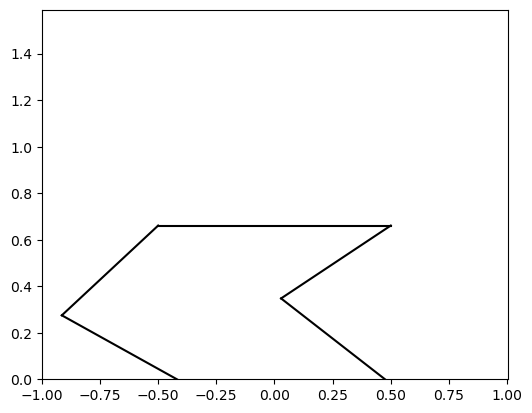

In [46]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,'x'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y'].value for n in range(1,N+1)])

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot upper leg 1
    th1A = m.q[i,'thb'].value+m.q[i,'thul1'].value
    uleg1_xt = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    uleg1_yt = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)
    uleg1_xb = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value) + m.len[('leg1',1)]*sin(th1A)
    uleg1_yb = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value) - m.len[('leg1',1)]*cos(th1A)
    ax.plot([uleg1_xt,uleg1_xb],[uleg1_yt,uleg1_yb],color='xkcd:black')
    
    #plot lower leg 1
    th1B = m.q[i,'thb'].value+m.q[i,'thul1'].value+m.q[i,'thll1'].value
    lleg1_xt = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value) + m.len[('leg1',1)]*sin(th1A)
    lleg1_yt = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value) - m.len[('leg1',1)]*cos(th1A)
    lleg1_xb = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value) + m.len[('leg1',1)]*sin(th1A) + m.len[('leg1',2)]*sin(th1B)
    lleg1_yb = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value) - m.len[('leg1',1)]*cos(th1A) - m.len[('leg1',2)]*cos(th1B)
    ax.plot([lleg1_xt,lleg1_xb],[lleg1_yt,lleg1_yb],color='xkcd:black')

    #plot upper leg 2
    th2A = m.q[i,'thb'].value+m.q[i,'thul2'].value
    uleg2_xt = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    uleg2_yt = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)
    uleg2_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value) + m.len[('leg2',1)]*sin(th2A)
    uleg2_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value) - m.len[('leg2',1)]*cos(th2A)
    ax.plot([uleg2_xt,uleg2_xb],[uleg2_yt,uleg2_yb],color='xkcd:black')
    
    #plot lower leg 2
    th2B = m.q[i,'thb'].value+m.q[i,'thul2'].value+m.q[i,'thll2'].value
    lleg2_xt = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value) + m.len[('leg2',1)]*sin(th2A)
    lleg2_yt = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value) - m.len[('leg2',1)]*cos(th2A)
    lleg2_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value) + m.len[('leg2',1)]*sin(th2A) + m.len[('leg2',2)]*sin(th2B)
    lleg2_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value) - m.len[('leg2',1)]*cos(th2A) - m.len[('leg2',2)]*cos(th2B)
    ax.plot([lleg2_xt,lleg2_xb],[lleg2_yt,lleg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [47]:
import csv

def write_trajectory_to_csv(m, filename):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        decimal_places=6
        for n in m.N:
            if (n == 1):
                duration = 1
            else:
                duration = hm*m.h[n].value
            row = [
                0,  # j1 (always 0)
                round(m.q[n, 'thul1'].value, decimal_places),  # j2
                round(m.q[n, 'thll1'].value, decimal_places),  # j3
                0,  # j4 (always 0)
                round(m.q[n, 'thul1'].value, decimal_places),  # j5 (same as j2)
                round(m.q[n, 'thll1'].value, decimal_places),  # j6 (same as j3)
                0,  # j7 (always 0)
                round(m.q[n, 'thul2'].value, decimal_places),  # j8
                round(m.q[n, 'thll2'].value, decimal_places),  # j9
                0,  # j10 (always 0)
                round(m.q[n, 'thul2'].value, decimal_places),  # j11 (same as j8)
                round(m.q[n, 'thll2'].value, decimal_places),  # j12 (same as j9)
                round(duration, 4)  # duration
            ]
            writer.writerow(row)

# Usage:
# Assuming 'm' is your Pyomo model
write_trajectory_to_csv(m, 'trajectory.csv')

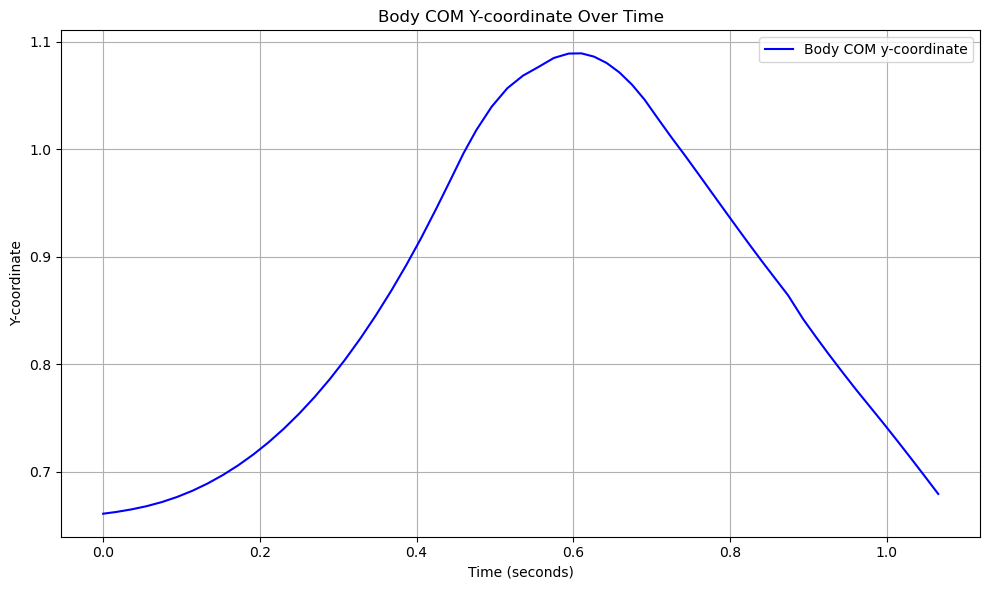

In [49]:
# Calculate real time values
base_time_step = 0.02  # base time step in seconds
cumulative_time = [0]  # Start with 0 for the initial position
for n in range(2, N+1):  # Start from the second time step
    cumulative_time.append(cumulative_time[-1] + base_time_step * m.h[n].value)

# Extract y-coordinate data for the body COM
body_y = [m.q[n,'y'].value for n in range(1, N+1)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_time, body_y, label='Body COM y-coordinate', color='blue')

plt.xlabel('Time (seconds)')
plt.ylabel('Y-coordinate')
plt.title('Body COM Y-coordinate Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/home/marty/Music/marty-pyomo-code/Pyomo/Plots/yCOM 2 early cost mass new.png')
plt.show()



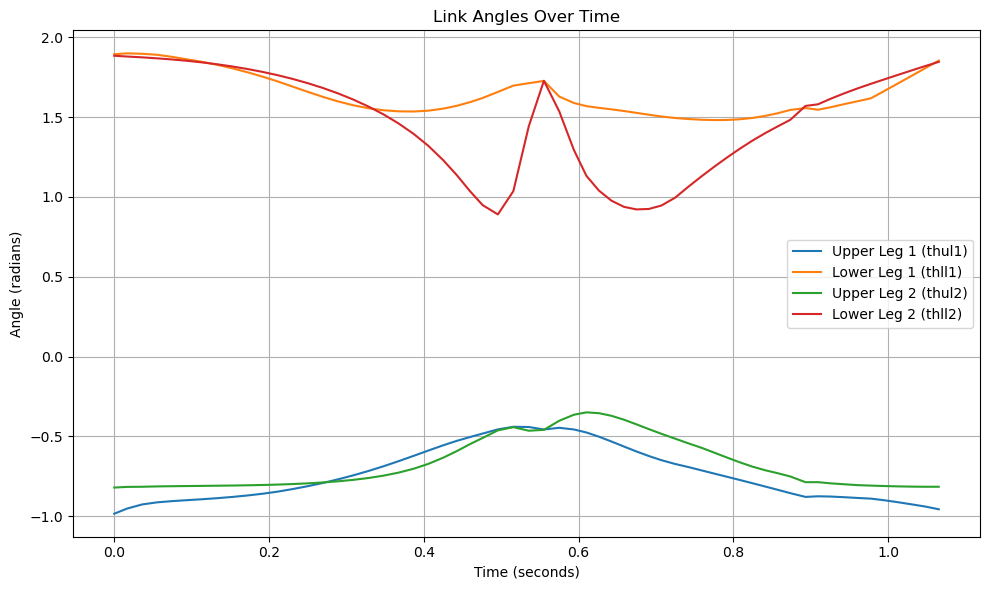

In [50]:
# Calculate real time values
base_time_step = 0.02  # base time step in seconds
cumulative_time = [0]  # Start with 0 for the initial position
for n in range(2, N+1):  # Start from the second time step
    cumulative_time.append(cumulative_time[-1] + base_time_step * m.h[n].value)

# Extract angle data
thul1 = [m.q[n,'thul1'].value for n in range(1, N+1)]
thll1 = [m.q[n,'thll1'].value for n in range(1, N+1)]
thul2 = [m.q[n,'thul2'].value for n in range(1, N+1)]
thll2 = [m.q[n,'thll2'].value for n in range(1, N+1)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_time, thul1, label='Upper Leg 1 (thul1)')
plt.plot(cumulative_time, thll1, label='Lower Leg 1 (thll1)')
plt.plot(cumulative_time, thul2, label='Upper Leg 2 (thul2)')
plt.plot(cumulative_time, thll2, label='Lower Leg 2 (thll2)')

plt.xlabel('Time (seconds)')
plt.ylabel('Angle (radians)')
plt.title('Link Angles Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/home/marty/Music/marty-pyomo-code/Pyomo/Plots/Angles 2 early cost mass new.png')
plt.show()

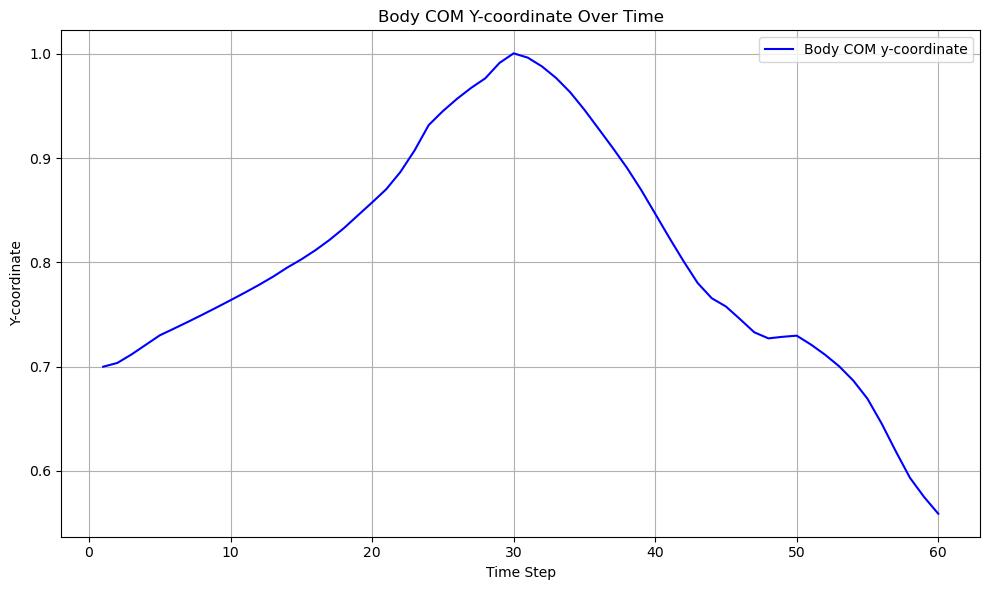

In [ ]:
# Extract y-coordinate data for the body COM
time = range(1, N+1)
body_y = [m.q[n,'y'].value for n in time]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, body_y, label='Body COM y-coordinate', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Y-coordinate')
plt.title('Body COM Y-coordinate Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

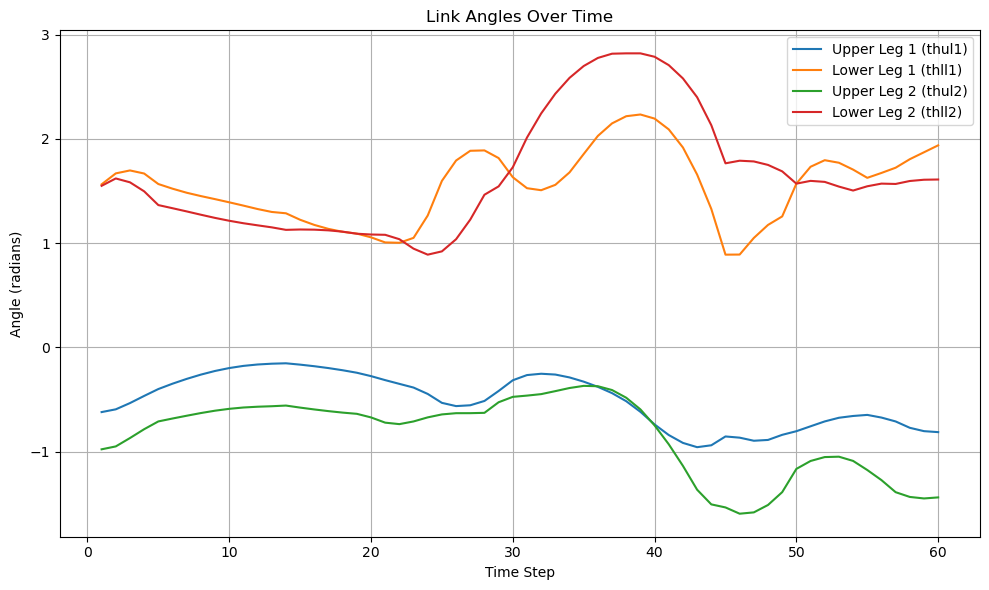

In [ ]:
# Extract angle data
time = range(1, N+1)

thul1 = [m.q[n,'thul1'].value for n in time]
thll1 = [m.q[n,'thll1'].value for n in time]
thul2 = [m.q[n,'thul2'].value for n in time]
thll2 = [m.q[n,'thll2'].value for n in time]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, thul1, label='Upper Leg 1 (thul1)')
plt.plot(time, thll1, label='Lower Leg 1 (thll1)')
plt.plot(time, thul2, label='Upper Leg 2 (thul2)')
plt.plot(time, thll2, label='Lower Leg 2 (thll2)')

plt.xlabel('Time Step')
plt.ylabel('Angle (radians)')
plt.title('Link Angles Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()